In [1]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
torch.cuda.is_available()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.7 MB/s eta 0:00:00

True

# Dataset

Para el analisis de sentimientos haremos uso del dataset Tweet Sentiment Extraction que tiene en total 31015 ejemplos de tweets, distribuidos de la siguiente manera:

*   27481 para entrenamiento
*   3534 para validacion

Ademas de tener 3 clases, las cuales serian las siguientes:

*   0: Negativo
*   1: Neutral
*   2: Positivo



In [2]:
dataset = load_dataset('mteb/tweet_sentiment_extraction')
dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/mteb___json/mteb--tweet_sentiment_extraction-0669dffec9427684/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

Los datos descargados lo asignamos a variables y estas las convertimos en dataframes.

In [3]:
train, test = dataset['train'].to_pandas(),  dataset['test'].to_pandas()
train

,id,text,label,label_text
0,cb774db0d1,"I`d have responded, if I were going",1,neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
2,088c60f138,my boss is bullying me...,0,negative
3,9642c003ef,what interview! leave me alone,0,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,0,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,0,negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,2,positive
27479,ed167662a5,But it was worth it ****.,2,positive


In [4]:
test

,id,text,label,label_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,2,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0,negative
3,01082688c6,happy bday!,2,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2,positive
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",0,negative
3530,416863ce47,All alone in this old house again. Thanks for...,2,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,0,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,2,positive


Ahora extraemos los datos tomando unicamente las columnas de texto y las etiquetas, tanto para el entrenamiento como para el test

In [5]:
train_tweets = train['text'].values
train_labels = train['label'].values

test_tweets = test['text'].values
test_labels = test['label'].values

# Tokenizador
Para este modelo descargaremos el tokenizador ya preentrenado en base a roberta. El cual es derivado del tokenizador GPT-2, utilizando la codificación de pares de bytes a nivel de byte. Este tokenizador ha sido entrenado para tratar los espacios como partes de los tokens (un poco como una oración), por lo que una palabra codificarse de manera diferente ya sea al comienzo de la oración (sin espacio) o no:

In [6]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer

RobertaTokenizer(name_or_path='roberta-base', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)}, clean_up_tokenization_spaces=True)

In [7]:
text = "Journey!? Wow... u just became cooler. hehe... (is that possible!?) "

# Codificar el texto en una secuencia de tokens
encoded_input = tokenizer.encode(text)

print(encoded_input)

[0, 863, 37786, 42648, 22545, 734, 1717, 95, 1059, 12924, 4, 37, 700, 734, 36, 354, 14, 678, 328, 16276, 1437, 2]


In [8]:
text = " Journey!? Wow... u just became cooler. hehe... (is that possible!?) "
encoded_input = tokenizer.encode(text)

print(encoded_input)

[0, 23635, 42648, 22545, 734, 1717, 95, 1059, 12924, 4, 37, 700, 734, 36, 354, 14, 678, 328, 16276, 1437, 2]


Este tokenizador hereda de PreTrainedTokenizer que contiene la mayoría de los métodos principales. Los usuarios deben consultar esta superclase para obtener más información sobre esos métodos.

# Modelo
Para el modelo se utilizo el modelo RoBERTa, que como tal es un modelo de lenguaje desarrollado por Facebook AI que se basa en la arquitectura de Transformer y está diseñado para tareas de procesamiento del lenguaje natural (NLP, por sus siglas en inglés). El nombre "RoBERTa" es un acrónimo de "Robustly Optimized BERT approach" (Enfoque BERT robustamente optimizado).

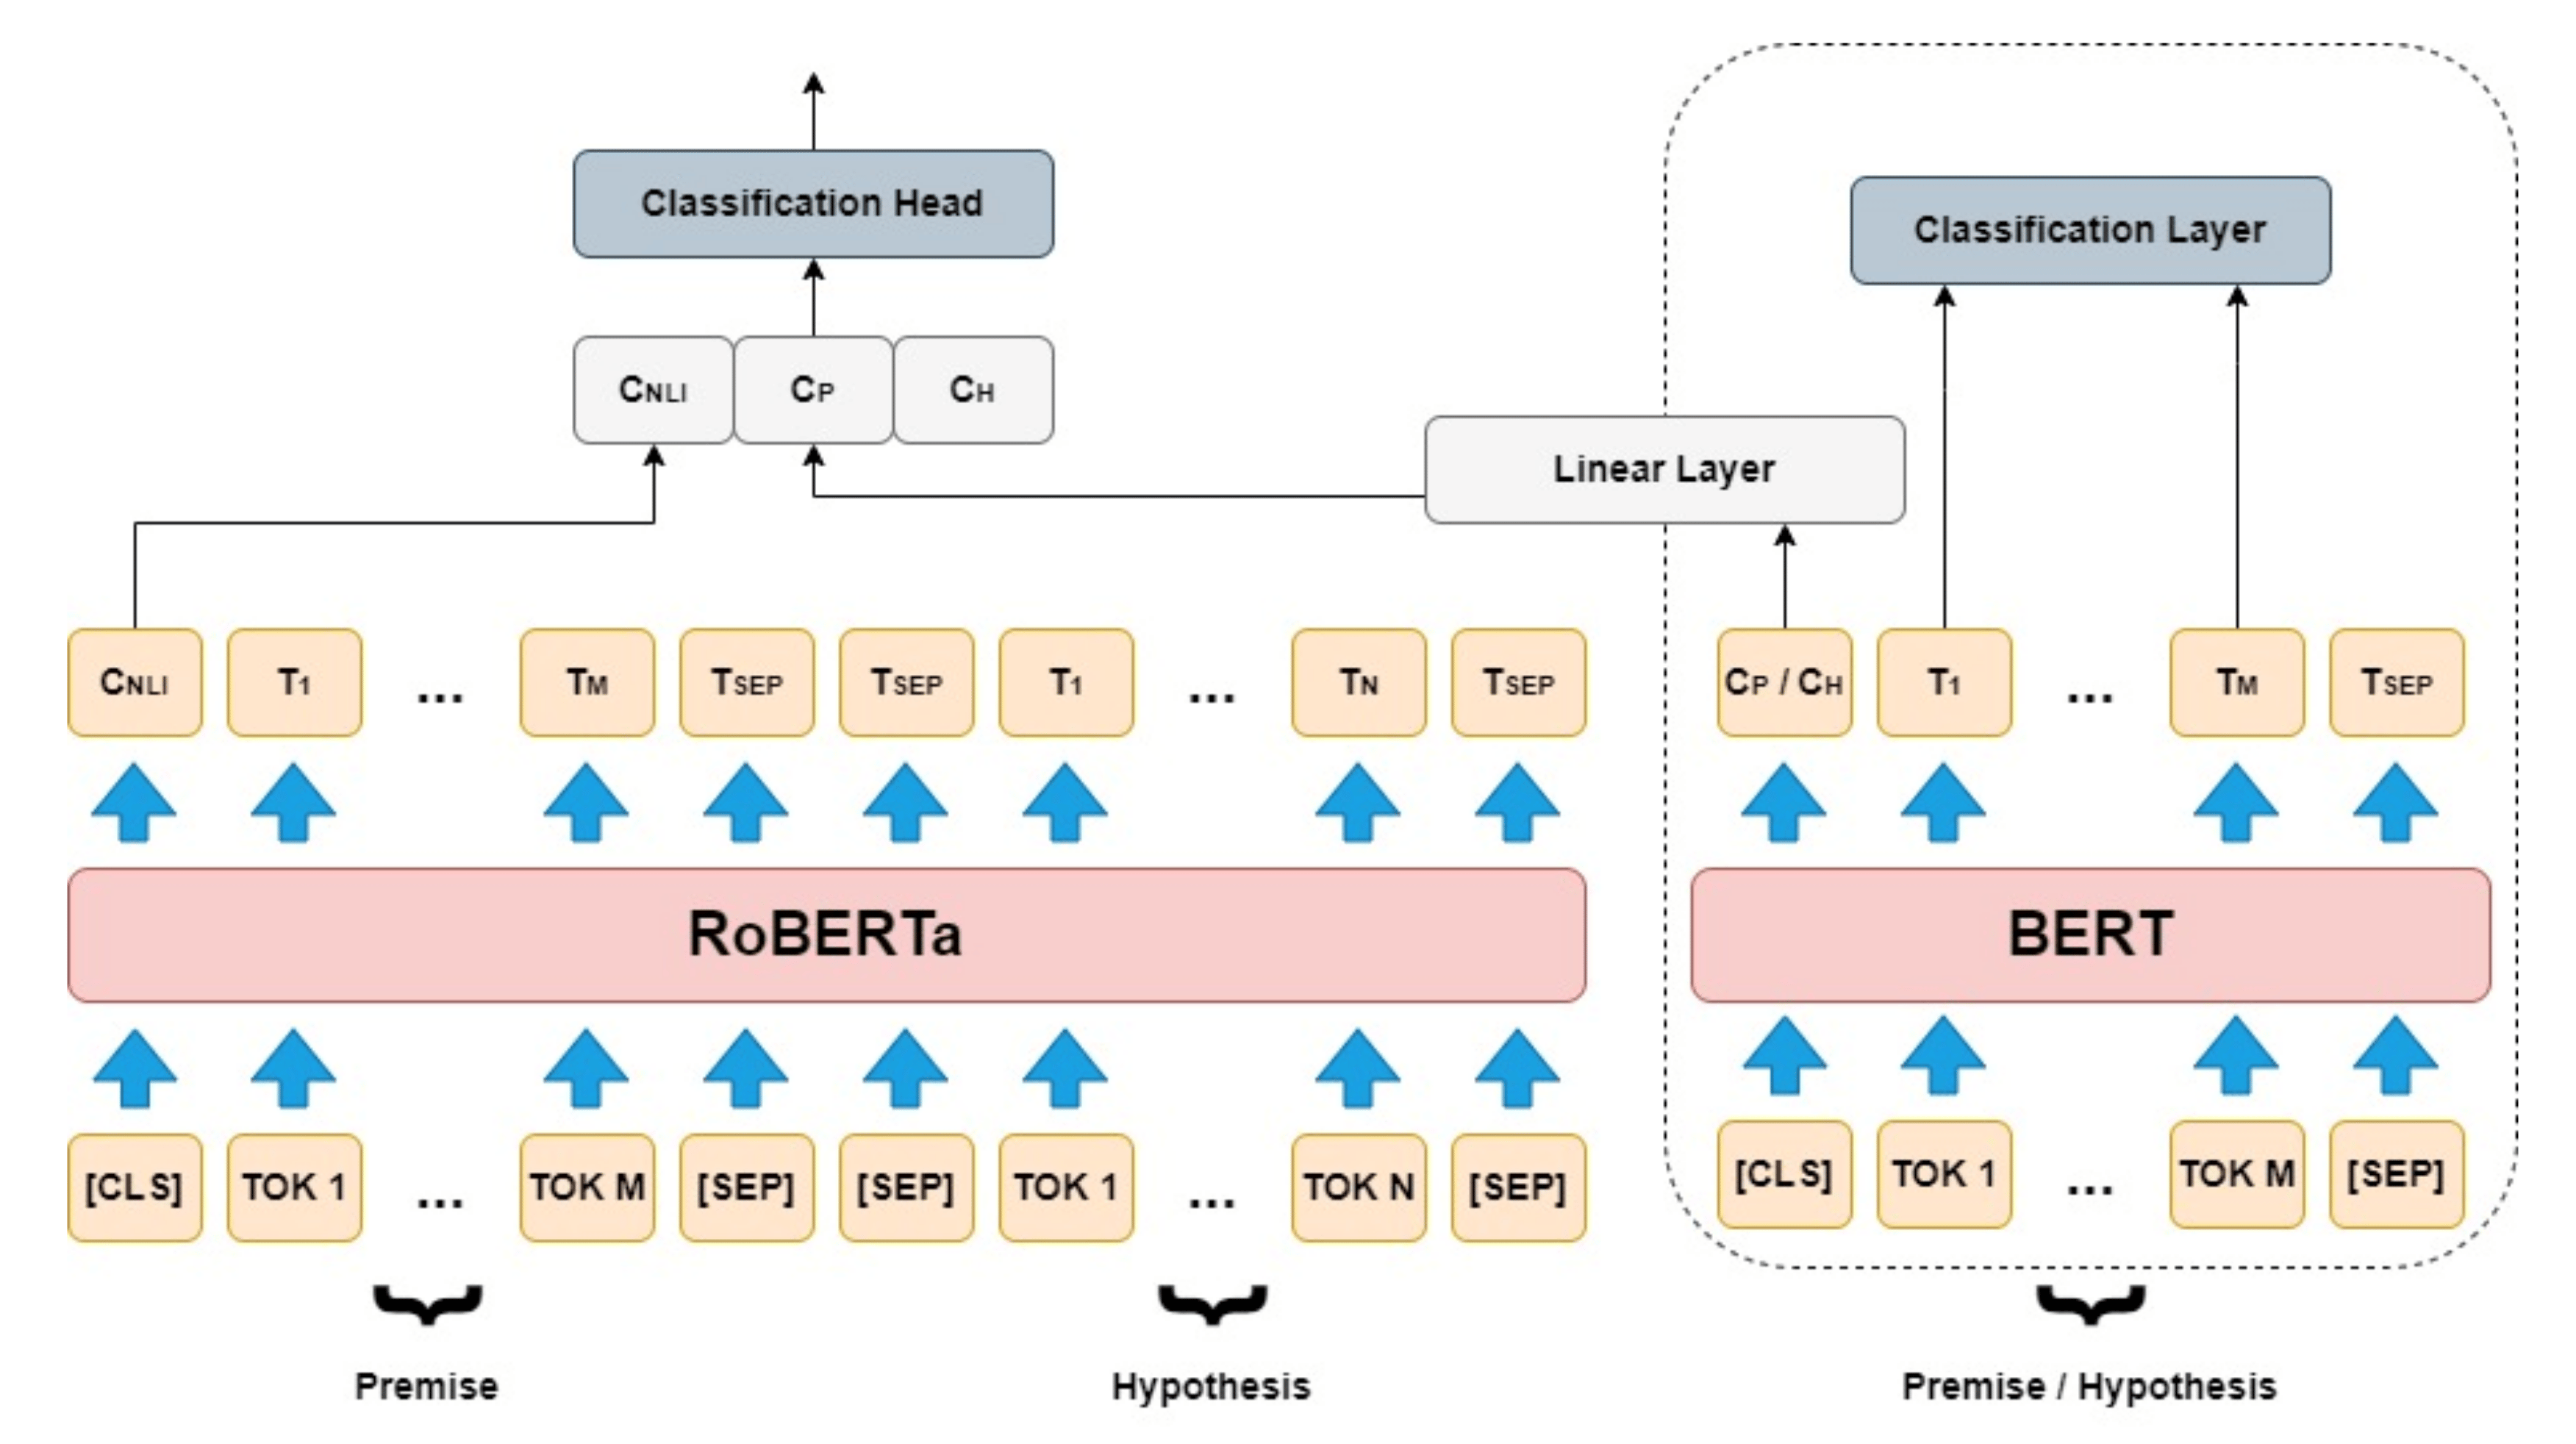

La arquitectura de Transformer se compone de dos componentes principales: el codificador (encoder) y el decodificador (decoder). En el caso de RoBERTa, solo se utiliza el codificador, ya que está diseñado principalmente para tareas de codificación o clasificación.

1.   Capa de atención multi-cabezal: Esta subcapa permite que el modelo capture las relaciones entre las palabras en una secuencia. Utiliza múltiples "cabezas" de atención para calcular las representaciones de atención entre las palabras en diferentes perspectivas. Esto ayuda al modelo a comprender las relaciones de dependencia y coherencia en el texto.
2.   Capa de normalización de capa (Layer Normalization): Después de cada subcapa de atención, se aplica una normalización de capa para estabilizar y normalizar las salidas.
3.   Capa de alimentación hacia adelante (Feed-forward): Esta subcapa consta de dos capas lineales con una función de activación intermedia, como ReLU (Rectified Linear Unit). Ayuda a aprender representaciones más complejas y no lineales de las palabras en el texto.

In [9]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should pr

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [11]:
# Convert the data to tensors and create dataloaders
train_encodings = tokenizer(list(train_tweets), truncation=True, padding=True, max_length=128)
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


test_encodings = tokenizer(list(test_tweets), truncation=True, padding=True, max_length=128)
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                              torch.tensor(test_encodings['attention_mask']),
                              torch.tensor(test_labels))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [12]:
# Set up optimizer, scheduler, and loss function
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Entrenamiento

In [13]:
# Train the model
model.train()
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for step, batch in enumerate(train_loader):

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        _, predicted_labels = torch.max(logits, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted_labels == labels).sum().item()

        running_loss += loss.item()

        if (step+1) % 10 == 0:
            accuracy = correct_predictions / total_predictions
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, epochs, step+1, len(train_loader), running_loss/100, accuracy))
            running_loss = 0.0


    scheduler.step()

print('Training complete.')

Epoch [1/5], Step [10/859], Loss: 0.1095, Accuracy: 0.3875
Epoch [1/5], Step [20/859], Loss: 0.1087, Accuracy: 0.4000
Epoch [1/5], Step [30/859], Loss: 0.0987, Accuracy: 0.4448
Epoch [1/5], Step [40/859], Loss: 0.0798, Accuracy: 0.4984
Epoch [1/5], Step [50/859], Loss: 0.0768, Accuracy: 0.5369
Epoch [1/5], Step [60/859], Loss: 0.0796, Accuracy: 0.5615
Epoch [1/5], Step [70/859], Loss: 0.0681, Accuracy: 0.5848
Epoch [1/5], Step [80/859], Loss: 0.0659, Accuracy: 0.6031
Epoch [1/5], Step [90/859], Loss: 0.0738, Accuracy: 0.6135
Epoch [1/5], Step [100/859], Loss: 0.0654, Accuracy: 0.6250
Epoch [1/5], Step [110/859], Loss: 0.0641, Accuracy: 0.6364
Epoch [1/5], Step [120/859], Loss: 0.0595, Accuracy: 0.6461
Epoch [1/5], Step [130/859], Loss: 0.0545, Accuracy: 0.6572
Epoch [1/5], Step [140/859], Loss: 0.0652, Accuracy: 0.6636
Epoch [1/5], Step [150/859], Loss: 0.0626, Accuracy: 0.6681
Epoch [1/5], Step [160/859], Loss: 0.0581, Accuracy: 0.6746
Epoch [1/5], Step [170/859], Loss: 0.0615, Accura

In [14]:
preds = []
y_labels = []
for step2, batch in enumerate(test_loader):
  print(step2)
  input_ids = batch[0].to(device)
  attention_mask = batch[1].to(device)
  labels = batch[2].to(device)

  optimizer.zero_grad()

  outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

  loss = outputs.loss
  logits = outputs.logits

  _, predicted_labels = torch.max(logits, 1)
  total_predictions += labels.size(0)
  preds.append(predicted_labels.cpu().detach().numpy().tolist())
  y_labels.append(labels.cpu().detach().numpy().tolist())

  correct_predictions += (predicted_labels == labels).sum().item()

  running_loss += loss.item()

print(correct_predictions/total_predictions)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
0.831597614057714


# Guardar el modelo

In [15]:
PATH = './RoBERTa_Sentiment_Analysis.pt'
torch.save(model.state_dict(), PATH)

# Generar Predicciones

In [16]:
model.eval()
text = "2am feedings for the baby are fun when he is all smiles and coos"
inputs = tokenizer.encode_plus(text, add_special_tokens=True, padding='longest', truncation=True, return_tensors="pt")
inputs

{'input_ids': tensor([[    0,   176,   424,  3993,  1033,    13,     5,  1928,    32,  1531,
            77,    37,    16,    70, 14504,     8,  1029,   366,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs = {k: v.to(device) for k, v in inputs.items()}
model = model.to(device)

outputs = model(**inputs)
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).flatten().tolist()

In [18]:
label_mapping = {0: "Negativo", 1: "Neutral", 2: "Positivo"}
predicted_labels = [label_mapping[label] for label in predicted_labels]
print(predicted_labels)

['Positivo']


In [19]:
#Test Negativo
text = "my whole body feels itchy and like its on fire"
inputs = tokenizer.encode_plus(text, add_special_tokens=True, padding='longest', truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
model = model.to(device)

outputs = model(**inputs)
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).flatten().tolist()
predicted_labels = [label_mapping[label] for label in predicted_labels]
print(predicted_labels)

['Negativo']


In [20]:
# Test Neutral
text = "talk all the nonsense and continue all the drama will vote for modi"
inputs = tokenizer.encode_plus(text, add_special_tokens=True, padding='longest', truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
model = model.to(device)

outputs = model(**inputs)
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).flatten().tolist()
predicted_labels = [label_mapping[label] for label in predicted_labels]
print(predicted_labels)

['Negativo']


In [22]:
# Test Positivo
text = "Happy Birthday Snickers!!!! ? I hope you have the best day ever! Let`s go shopping!!!"
inputs = tokenizer.encode_plus(text, add_special_tokens=True, padding='longest', truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
model = model.to(device)

outputs = model(**inputs)
logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1).flatten().tolist()
predicted_labels = [label_mapping[label] for label in predicted_labels]
print(predicted_labels)

['Positivo']
